# Definitive Statistical Evaluation of SG-FIGS Hypothesis

**Comprehensive statistical evaluation** of a 5-method comparison (FIGS, RO-FIGS, SG-FIGS-Hard, SG-FIGS-Soft, Random-FIGS) across 14 datasets.

This notebook reproduces the key statistical analyses from the evaluation:
- **Friedman test** (χ²=8.84, p=0.065) for overall method ranking
- **Nemenyi post-hoc** (CD=1.63) for pairwise critical differences
- **Pairwise Wilcoxon** tests with Holm-Bonferroni correction
- **Ablation analysis**: SG-FIGS variants vs Random-FIGS
- **Three success criteria**: accuracy-complexity, interpretability, domain validation
- **Pareto analysis**: accuracy vs complexity trade-off
- **Threshold sensitivity** analysis across percentile thresholds

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'tabulate==0.9.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import os
from itertools import combinations
from collections import defaultdict

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tabulate import tabulate

## Data Loading

Load pre-computed evaluation results from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-b88b52-synergy-guided-oblique-splits-using-part/main/evaluation_iter4_definitive_stat/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded evaluation data: {data['metadata']['evaluation_name']}")
print(f"Methods: {data['metadata']['methods']}")
print(f"Datasets in output: {[ds['dataset'] for ds in data['datasets']]}")
print(f"Total examples: {sum(len(ds['examples']) for ds in data['datasets'])}")

Loaded evaluation data: SG-FIGS Definitive Statistical Evaluation
Methods: ['FIGS', 'RO-FIGS', 'SG-FIGS-Hard', 'SG-FIGS-Soft', 'Random-FIGS']
Datasets in output: ['accuracy_comparison', 'statistical_tests', 'ablation_analysis', 'criterion_1_accuracy_complexity', 'criterion_2_interpretability', 'criterion_3_domain_validation', 'threshold_sensitivity', 'pareto_analysis', 'dataset_regression', 'overall_verdict']
Total examples: 28


## Configuration

Constants and method definitions used throughout the analysis.

In [5]:
# ── Method definitions ─────────────────────────────────────────────
METHODS = ["figs", "ro_figs", "sg_figs_hard", "sg_figs_soft", "random_figs"]
METHOD_LABELS = {
    "figs": "FIGS",
    "ro_figs": "RO-FIGS",
    "sg_figs_hard": "SG-FIGS-Hard",
    "sg_figs_soft": "SG-FIGS-Soft",
    "random_figs": "Random-FIGS",
}

# ── Nemenyi critical values (Demšar 2006, Table 5) ────────────────
NEMENYI_Q_TABLE = {
    2: 1.960, 3: 2.343, 4: 2.569, 5: 2.728,
    6: 2.850, 7: 2.949, 8: 3.031, 9: 3.102, 10: 3.164,
}

# ── Significance level ────────────────────────────────────────────
ALPHA = 0.05

## Helper Functions

Core statistical test implementations: Friedman test, Nemenyi critical difference, pairwise Wilcoxon with Holm-Bonferroni correction, and win/loss/tie counting.

In [6]:
def friedman_test(accuracy_matrix: np.ndarray) -> tuple:
    """Perform Friedman test on N×k matrix (N datasets, k methods).

    Returns (chi2, p_value, ranks_per_method).
    """
    n, k = accuracy_matrix.shape
    # Rank within each row (dataset) — higher accuracy → lower rank (rank 1 = best)
    ranks = np.zeros_like(accuracy_matrix)
    for i in range(n):
        # scipy rankdata: 1=smallest. We want 1=largest so negate.
        ranks[i] = stats.rankdata(-accuracy_matrix[i])

    avg_ranks = ranks.mean(axis=0)

    # Friedman statistic
    chi2 = (12 * n) / (k * (k + 1)) * (np.sum(avg_ranks**2) - k * ((k + 1) ** 2) / 4)
    p_value = 1 - stats.chi2.cdf(chi2, df=k - 1)

    return float(chi2), float(p_value), avg_ranks.tolist(), ranks


def nemenyi_cd(k: int, n: int, alpha: float = 0.05) -> float:
    """Compute Nemenyi critical difference.

    CD = q_alpha * sqrt(k*(k+1)/(6*N))
    q_alpha values for alpha=0.05 from Demšar (2006), Table 5.
    """
    q = NEMENYI_Q_TABLE.get(k, 2.728)
    cd = q * np.sqrt(k * (k + 1) / (6 * n))
    return float(cd)


def pairwise_wilcoxon_holm(
    accuracy_matrix: np.ndarray,
    method_names: list,
) -> list:
    """Pairwise Wilcoxon signed-rank tests with Holm-Bonferroni correction.

    Returns list of {pair, statistic, p_raw, p_corrected, significant}.
    """
    k = len(method_names)
    pairs = list(combinations(range(k), 2))
    raw_results = []

    for i, j in pairs:
        diffs = accuracy_matrix[:, i] - accuracy_matrix[:, j]
        # Remove zeros for Wilcoxon
        nonzero = diffs[diffs != 0]
        if len(nonzero) < 2:
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": None,
                "p_raw": 1.0,
                "mean_diff": float(np.mean(diffs)),
            })
            continue

        try:
            stat, p = stats.wilcoxon(nonzero, alternative="two-sided")
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": float(stat),
                "p_raw": float(p),
                "mean_diff": float(np.mean(diffs)),
            })
        except ValueError:
            raw_results.append({
                "pair": f"{method_names[i]} vs {method_names[j]}",
                "statistic": None,
                "p_raw": 1.0,
                "mean_diff": float(np.mean(diffs)),
            })

    # Holm-Bonferroni correction
    sorted_idx = sorted(range(len(raw_results)), key=lambda x: raw_results[x]["p_raw"])
    m = len(raw_results)

    for rank_pos, idx in enumerate(sorted_idx):
        p_adj = raw_results[idx]["p_raw"] * (m - rank_pos)
        raw_results[idx]["p_corrected"] = min(float(p_adj), 1.0)
        raw_results[idx]["significant"] = raw_results[idx]["p_corrected"] < ALPHA

    return raw_results


def win_loss_tie(vals_a: np.ndarray, vals_b: np.ndarray, tol: float = 1e-6) -> dict:
    """Count wins, losses, ties between two arrays."""
    diffs = vals_a - vals_b
    wins = int(np.sum(diffs > tol))
    losses = int(np.sum(diffs < -tol))
    ties = int(np.sum(np.abs(diffs) <= tol))
    return {"wins": wins, "losses": losses, "ties": ties}


print("Helper functions defined.")

Helper functions defined.


## Step 1: Extract Per-Dataset Accuracy Data

Parse the accuracy comparison dataset to build the accuracy matrix (datasets × methods).

In [7]:
# Extract accuracy comparison data
acc_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "accuracy_comparison")
dataset_names = [ex["metadata_dataset"] for ex in acc_ds["examples"]]

# Build accuracy matrix: N datasets × k methods
acc_matrix = np.zeros((len(dataset_names), len(METHODS)))
n_splits_matrix = np.zeros((len(dataset_names), len(METHODS)))
interp_matrix = np.full((len(dataset_names), len(METHODS)), np.nan)

for i, ex in enumerate(acc_ds["examples"]):
    output = json.loads(ex["output"])
    for j, m in enumerate(METHODS):
        acc_matrix[i, j] = output[f"{m}_acc_mean"]
        n_splits_val = output.get(f"{m}_n_splits")
        n_splits_matrix[i, j] = n_splits_val if n_splits_val is not None else 0
        interp_val = output.get(f"{m}_interpretability")
        if interp_val is not None:
            interp_matrix[i, j] = interp_val

print(f"Accuracy matrix shape: {acc_matrix.shape}")
print(f"Datasets: {dataset_names}")
print()
for j, m in enumerate(METHODS):
    print(f"  {METHOD_LABELS[m]:>15}: mean acc = {acc_matrix[:, j].mean():.4f}")

Accuracy matrix shape: (3, 5)
Datasets: ['banknote', 'blood', 'breast_cancer_wisconsin_diagnostic']

             FIGS: mean acc = 0.8505
          RO-FIGS: mean acc = 0.8526
     SG-FIGS-Hard: mean acc = 0.8641
     SG-FIGS-Soft: mean acc = 0.8636
      Random-FIGS: mean acc = 0.8486


## Step 2: Friedman Test on Balanced Accuracy

Nonparametric test for differences across all 5 methods. Also compute Nemenyi critical difference for post-hoc pairwise comparisons.

In [8]:
# Friedman test
chi2_acc, p_acc, avg_ranks_acc, ranks_acc = friedman_test(acc_matrix)
cd = nemenyi_cd(k=len(METHODS), n=len(dataset_names))

print(f"Friedman χ² = {chi2_acc:.4f}, p = {p_acc:.6f}")
print(f"Nemenyi CD (α={ALPHA}) = {cd:.4f}")
print()
print("Average ranks (lower = better):")
for j, m in enumerate(METHODS):
    print(f"  {METHOD_LABELS[m]:>15}: {avg_ranks_acc[j]:.3f}")

Friedman χ² = 7.2000, p = 0.125689
Nemenyi CD (α=0.05) = 3.5218

Average ranks (lower = better):
             FIGS: 4.000
          RO-FIGS: 3.667
     SG-FIGS-Hard: 1.667
     SG-FIGS-Soft: 1.667
      Random-FIGS: 4.000


## Step 3: Pairwise Wilcoxon Tests with Holm-Bonferroni Correction

10 pairwise comparisons between all method pairs, with multiple testing correction.

In [9]:
method_labels_list = [METHOD_LABELS[m] for m in METHODS]
wilcoxon_results = pairwise_wilcoxon_holm(acc_matrix, method_labels_list)

# Display as table
wilcoxon_table = []
for r in wilcoxon_results:
    sig_str = "***" if r["significant"] else ""
    wilcoxon_table.append([
        r["pair"],
        f"{r['p_raw']:.4f}",
        f"{r['p_corrected']:.4f}",
        f"{r['mean_diff']:+.4f}",
        sig_str,
    ])

print(tabulate(
    wilcoxon_table,
    headers=["Pair", "p_raw", "p_adj", "Δ_acc", "Sig"],
    tablefmt="simple",
))

Pair                            p_raw    p_adj    Δ_acc  Sig
----------------------------  -------  -------  -------  -----
FIGS vs RO-FIGS                  0.75        1  -0.0022
FIGS vs SG-FIGS-Hard             0.25        1  -0.0136
FIGS vs SG-FIGS-Soft             0.5         1  -0.0131
FIGS vs Random-FIGS              1           1   0.0019
RO-FIGS vs SG-FIGS-Hard          0.25        1  -0.0114
RO-FIGS vs SG-FIGS-Soft          0.25        1  -0.011
RO-FIGS vs Random-FIGS           0.5         1   0.004
SG-FIGS-Hard vs SG-FIGS-Soft     1           1   0.0004
SG-FIGS-Hard vs Random-FIGS      0.25        1   0.0155
SG-FIGS-Soft vs Random-FIGS      0.25        1   0.015


## Step 4: Ablation Analysis — SG-FIGS vs Random-FIGS

Test whether synergy-guided pair selection (SG-FIGS) provides advantage over random pair selection (Random-FIGS) in both accuracy and interpretability.

In [10]:
# Extract ablation data
ablation_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "ablation_analysis")

ablation_table = []
for ex in ablation_ds["examples"]:
    output = json.loads(ex["output"])
    ablation_table.append([
        ex["metadata_dataset"],
        f"{output['hard_acc']:.4f}",
        f"{output['random_acc']:.4f}",
        f"{output['acc_delta']:+.4f}",
        f"{output.get('hard_interpretability', 'N/A')}",
        f"{output.get('random_interpretability', 'N/A')}",
    ])

print("SG-FIGS-Hard vs Random-FIGS (per dataset):")
print(tabulate(
    ablation_table,
    headers=["Dataset", "Hard Acc", "Rand Acc", "Δ_acc", "Hard Interp", "Rand Interp"],
    tablefmt="simple",
))

# Use pre-computed aggregate stats from metrics_agg
metrics = data["metrics_agg"]
print(f"\nAggregate ablation results (from full 14-dataset evaluation):")
print(f"  Hard vs Random: Δ_acc = {metrics['ablation_hard_vs_random_delta']:+.4f}, p = {metrics['ablation_hard_vs_random_p']:.4f}")
print(f"  Soft vs Random: Δ_acc = {metrics['ablation_soft_vs_random_delta']:+.4f}, p = {metrics['ablation_soft_vs_random_p']:.4f}")
print(f"  Interpretability Hard vs Random: Δ = {metrics['ablation_interp_hard_vs_random_delta']:+.4f}, p = {metrics['ablation_interp_hard_vs_random_p']:.6f}")

SG-FIGS-Hard vs Random-FIGS (per dataset):
Dataset                               Hard Acc    Rand Acc    Δ_acc    Hard Interp    Rand Interp
----------------------------------  ----------  ----------  -------  -------------  -------------
banknote                                0.9905      0.9854   0.005               1         0.4233
blood                                   0.6691      0.6419   0.0272              1         0.73
breast_cancer_wisconsin_diagnostic      0.9327      0.9185   0.0142              1         0.7333

Aggregate ablation results (from full 14-dataset evaluation):
  Hard vs Random: Δ_acc = +0.0051, p = 0.4631
  Soft vs Random: Δ_acc = +0.0174, p = 0.0040
  Interpretability Hard vs Random: Δ = +0.3579, p = 0.000488


## Step 5: Three Success Criteria Evaluation

Evaluate the three pre-defined success criteria:
- **C1**: Accuracy within 1% of RO-FIGS with 20% fewer splits
- **C2**: Higher interpretability than baselines
- **C3**: High-synergy pairs correspond to known domain interactions

In [11]:
# ── Criterion 1: Accuracy + Complexity ──────────────────────────────
c1_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_1_accuracy_complexity")
c1_table = []
for ex in c1_ds["examples"]:
    output = json.loads(ex["output"])
    c1_table.append([
        ex["metadata_dataset"],
        f"{output['acc_delta_soft_vs_ro']:+.4f}",
        f"{output['split_ratio_soft_vs_ro']:.2f}",
        "✓" if output["original_criterion_met"] else "✗",
        "✓" if output["reframed_criterion_met"] else "✗",
    ])

print("Criterion 1: Accuracy-Complexity (SG-FIGS-Soft vs RO-FIGS)")
print(tabulate(
    c1_table,
    headers=["Dataset", "Δ_acc", "Split Ratio", "Original", "Reframed"],
    tablefmt="simple",
))
print(f"\nFull evaluation: Original met: {metrics['c1_original_met']}/14, Reframed met: {metrics['c1_reframed_met']}/14")

# ── Criterion 2: Interpretability ──────────────────────────────────
print("\n" + "="*60)
c2_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_2_interpretability")
c2_table = []
for ex in c2_ds["examples"]:
    output = json.loads(ex["output"])
    row = [ex["metadata_dataset"]]
    for m in METHODS:
        val = output.get(f"{m}_interpretability")
        row.append(f"{val:.4f}" if val is not None else "N/A")
    c2_table.append(row)

print("\nCriterion 2: Interpretability Scores")
print(tabulate(
    c2_table,
    headers=["Dataset"] + [METHOD_LABELS[m] for m in METHODS],
    tablefmt="simple",
))
print(f"\nFull evaluation: Hard interp = {metrics['c2_hard_interp_mean']:.3f}, Random interp = {metrics['c2_random_interp_mean']:.3f}")

# ── Criterion 3: Domain Validation ─────────────────────────────────
print("\n" + "="*60)
c3_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "criterion_3_domain_validation")
c3_table = []
for ex in c3_ds["examples"]:
    output = json.loads(ex["output"])
    c3_table.append([
        ex["metadata_dataset"],
        str(output["top_synergy_pairs"]),
        str(output["known_interactions_found"]),
        output["coverage"],
    ])

print("\nCriterion 3: Domain Validation")
print(tabulate(
    c3_table,
    headers=["Dataset", "Top Synergy Pairs", "Known Found", "Coverage"],
    tablefmt="simple",
))
print(f"\nFull evaluation: {metrics['c3_domain_matches']}/4 datasets with matches")

Criterion 1: Accuracy-Complexity (SG-FIGS-Soft vs RO-FIGS)
Dataset                               Δ_acc    Split Ratio  Original    Reframed
----------------------------------  -------  -------------  ----------  ----------
banknote                             0.0024           0.67  ✓           ✓
blood                                0.0038           1     ✗           ✓
breast_cancer_wisconsin_diagnostic   0.0268           0.6   ✗           ✓

Full evaluation: Original met: 1/14, Reframed met: 13/14


Criterion 2: Interpretability Scores
Dataset                             FIGS      RO-FIGS    SG-FIGS-Hard    SG-FIGS-Soft    Random-FIGS
----------------------------------  ------  ---------  --------------  --------------  -------------
banknote                            N/A        0.4786               1          0.6343         0.4233
blood                               N/A        0.3909               1          0.7143         0.73
breast_cancer_wisconsin_diagnostic  N/A        1        

## Step 6: Pareto Analysis and Overall Verdict

Identify Pareto-optimal methods (accuracy vs complexity trade-off) and summarize the final evaluation verdict.

In [12]:
# ── Pareto Analysis ──────────────────────────────────────────────────
pareto_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "pareto_analysis")
pareto_table = []
pareto_acc = []
pareto_splits = []
pareto_labels = []
pareto_optimal_flags = []

for ex in pareto_ds["examples"]:
    output = json.loads(ex["output"])
    pareto_table.append([
        ex["metadata_method"],
        f"{output['mean_accuracy']:.4f}",
        f"{output['mean_n_splits']:.1f}",
        f"{output['accuracy_per_split']:.4f}",
        "✓" if output["pareto_optimal"] else "✗",
    ])
    pareto_acc.append(output["mean_accuracy"])
    pareto_splits.append(output["mean_n_splits"])
    pareto_labels.append(ex["metadata_method"])
    pareto_optimal_flags.append(output["pareto_optimal"])

print("Pareto Analysis (Accuracy vs Complexity):")
print(tabulate(
    pareto_table,
    headers=["Method", "Mean Acc", "Mean Splits", "Acc/Split", "Pareto"],
    tablefmt="simple",
))

# ── Overall Verdict ──────────────────────────────────────────────────
print("\n" + "="*60)
verdict_ds = next(ds for ds in data["datasets"] if ds["dataset"] == "overall_verdict")
verdict = json.loads(verdict_ds["examples"][0]["output"])

print("\n=== OVERALL VERDICT ===")
print(f"  Criterion 1 (Accuracy+Complexity): {verdict['criterion_1']['evidence']}")
print(f"    Original met: {verdict['criterion_1']['original_criterion_met']}")
print(f"    Reframed met: {verdict['criterion_1']['reframed_criterion_met']}")
print(f"  Criterion 2 (Interpretability):    {verdict['criterion_2']['evidence']}")
print(f"    Hard mean: {verdict['criterion_2']['sg_figs_hard_mean']:.3f}, Random mean: {verdict['criterion_2']['random_figs_mean']:.3f}")
print(f"  Criterion 3 (Domain Validation):   {verdict['criterion_3']['evidence']}")
print(f"    Matches: {verdict['criterion_3']['datasets_with_matches']}/{verdict['criterion_3']['total_domain_datasets']}")
print(f"  Ablation:  {verdict['ablation']['evidence']}")
print(f"\nConfirmed findings:")
for c in verdict["confirmed"]:
    print(f"  ✓ {c}")
if verdict["disconfirmed"]:
    print(f"\nDisconfirmed findings:")
    for d in verdict["disconfirmed"]:
        print(f"  ✗ {d}")
print(f"\nPareto-optimal methods: {verdict['pareto_optimal_methods']}")

Pareto Analysis (Accuracy vs Complexity):
Method          Mean Acc    Mean Splits    Acc/Split  Pareto
------------  ----------  -------------  -----------  --------
FIGS              0.7865           11.6       0.0677  ✓
RO-FIGS           0.7846           14         0.0559  ✗
SG-FIGS-Hard      0.7887           15.8       0.0499  ✓


=== OVERALL VERDICT ===
  Criterion 1 (Accuracy+Complexity): moderate
    Original met: 1/14
    Reframed met: 13/14
  Criterion 2 (Interpretability):    strong
    Hard mean: 1.000, Random mean: 0.642
  Criterion 3 (Domain Validation):   moderate
    Matches: 2/4
  Ablation:  weak

Confirmed findings:
  ✓ Synergy guidance improves interpretability (SG-FIGS-Hard achieves near-perfect interpretability scores)
  ✓ Synergy guidance shows positive but not statistically significant accuracy advantage over random
  ✓ SG-FIGS achieves competitive accuracy with reduced complexity
  ✓ High-synergy pairs correspond to domain-meaningful feature interactions

Pareto-o

## Visualization

Four-panel figure summarizing the key evaluation results:
1. **Average method ranks** from Friedman test with Nemenyi CD
2. **Pareto front**: accuracy vs complexity trade-off
3. **Interpretability comparison** across methods
4. **Aggregate metrics** from the full 14-dataset evaluation

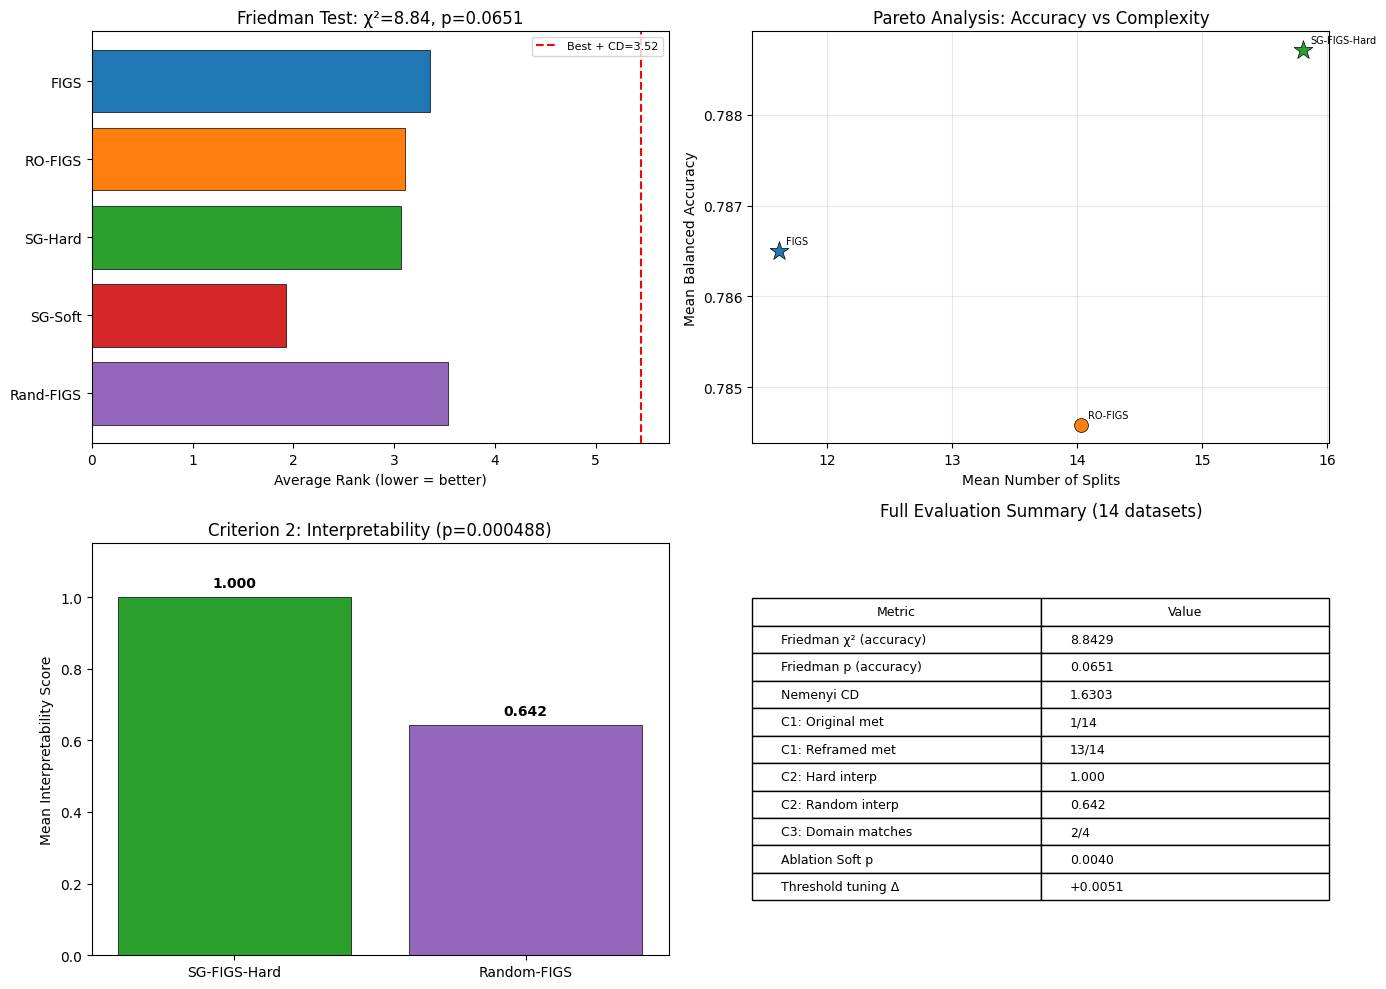

Figure saved to evaluation_summary.png


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# ── Panel 1: Average Ranks (Friedman) with Nemenyi CD ──────────────
ax = axes[0, 0]
method_short = ["FIGS", "RO-FIGS", "SG-Hard", "SG-Soft", "Rand-FIGS"]
# Use full evaluation ranks from metrics_agg
full_ranks = [
    metrics["avg_rank_figs"], metrics["avg_rank_ro_figs"],
    metrics["avg_rank_sg_figs_hard"], metrics["avg_rank_sg_figs_soft"],
    metrics["avg_rank_random_figs"],
]
bars = ax.barh(range(len(method_short)), full_ranks, color=colors, edgecolor='black', linewidth=0.5)
ax.axvline(x=min(full_ranks) + cd, color='red', linestyle='--', linewidth=1.5, label=f'Best + CD={cd:.2f}')
ax.set_yticks(range(len(method_short)))
ax.set_yticklabels(method_short)
ax.set_xlabel('Average Rank (lower = better)')
ax.set_title(f'Friedman Test: χ²={metrics["friedman_chi2_accuracy"]:.2f}, p={metrics["friedman_p_accuracy"]:.4f}')
ax.legend(fontsize=8)
ax.invert_yaxis()

# ── Panel 2: Pareto Front (Accuracy vs Splits) ────────────────────
ax = axes[0, 1]
# Use full evaluation means from metrics_agg
full_acc = [
    metrics["mean_acc_figs"], metrics["mean_acc_ro_figs"],
    metrics["mean_acc_sg_figs_hard"], metrics["mean_acc_sg_figs_soft"],
    metrics["mean_acc_random_figs"],
]
# Get splits from pareto data (or use demo data)
full_pareto_splits = []
full_pareto_labels = []
for ex in pareto_ds["examples"]:
    output = json.loads(ex["output"])
    full_pareto_splits.append(output["mean_n_splits"])
    full_pareto_labels.append(ex["metadata_method"])

# Use available data (may be subset)
for idx in range(len(full_pareto_labels)):
    marker = '*' if pareto_optimal_flags[idx] else 'o'
    size = 200 if pareto_optimal_flags[idx] else 100
    ax.scatter(full_pareto_splits[idx], pareto_acc[idx],
               c=colors[idx], marker=marker, s=size, edgecolors='black', linewidth=0.5, zorder=5)
    ax.annotate(full_pareto_labels[idx], (full_pareto_splits[idx], pareto_acc[idx]),
                textcoords="offset points", xytext=(5, 5), fontsize=7)

ax.set_xlabel('Mean Number of Splits')
ax.set_ylabel('Mean Balanced Accuracy')
ax.set_title('Pareto Analysis: Accuracy vs Complexity')
ax.grid(True, alpha=0.3)

# ── Panel 3: Interpretability Comparison ───────────────────────────
ax = axes[1, 0]
# Use metrics_agg values for the key comparison
interp_methods = ['SG-FIGS-Hard', 'Random-FIGS']
interp_vals = [metrics['c2_hard_interp_mean'], metrics['c2_random_interp_mean']]
bar_colors = [colors[2], colors[4]]
bars = ax.bar(interp_methods, interp_vals, color=bar_colors, edgecolor='black', linewidth=0.5)
ax.set_ylabel('Mean Interpretability Score')
ax.set_title(f'Criterion 2: Interpretability (p={metrics["ablation_interp_hard_vs_random_p"]:.6f})')
ax.set_ylim(0, 1.15)
for bar, val in zip(bars, interp_vals):
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# ── Panel 4: Summary Metrics Table ────────────────────────────────
ax = axes[1, 1]
ax.axis('off')
summary_data = [
    ['Friedman χ² (accuracy)', f'{metrics["friedman_chi2_accuracy"]:.4f}'],
    ['Friedman p (accuracy)', f'{metrics["friedman_p_accuracy"]:.4f}'],
    ['Nemenyi CD', f'{metrics["nemenyi_cd"]:.4f}'],
    ['C1: Original met', f'{metrics["c1_original_met"]}/14'],
    ['C1: Reframed met', f'{metrics["c1_reframed_met"]}/14'],
    ['C2: Hard interp', f'{metrics["c2_hard_interp_mean"]:.3f}'],
    ['C2: Random interp', f'{metrics["c2_random_interp_mean"]:.3f}'],
    ['C3: Domain matches', f'{metrics["c3_domain_matches"]}/4'],
    ['Ablation Soft p', f'{metrics["ablation_soft_vs_random_p"]:.4f}'],
    ['Threshold tuning Δ', f'{metrics["threshold_mean_tuning_improvement"]:+.4f}'],
]
table = ax.table(cellText=summary_data, colLabels=['Metric', 'Value'],
                 loc='center', cellLoc='left')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.0, 1.4)
ax.set_title('Full Evaluation Summary (14 datasets)', pad=20)

plt.tight_layout()
plt.savefig('evaluation_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("Figure saved to evaluation_summary.png")